In [1]:
# Import libraries
import netCDF4 as nc
import xarray as xr
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import matplotlib.patheffects as path_effects
import numpy as np
import cartopy.util as cutil
import xarray as xr
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [13]:
# Assign file, set levels, data processing
de = xr.open_dataset('/scratch/mch/fackerma/orders/case_150619/ERA5_data/24bef9879b8ec6a103057e622d524190.nc')


# Calculate wind speed at 850 or 500 hPa
de=de.assign(wind_speed=lambda de: (de.u**2 + de.v**2)**0.5 )

# Calculate temperature into degrees
de=de.assign(t_celsius=lambda de: (de.t - 273.15))

# From geopotential to geopotential height
de=de.assign(z_m=lambda de: (de.z / 9.80665))

# Assign humidity
de=de.assign(q_g=lambda de: (de.q*1000))

# r Relative Humidity
# t air temperature
# w Vertical wind
# z Geopotential 
# q specific humidity

# Change longitudes
de.coords['longitude'] = (de.coords['longitude'] + 180) % 360 - 180
de = de.sortby(de.longitude)


# Set custom levels
z500_levels= np.arange(5000,6000,50)
z850_levels= np.arange(1000,2000,25)
r_levels = np.arange(0, 101, 10)

In [50]:
# Set aim time
aim_time = 40

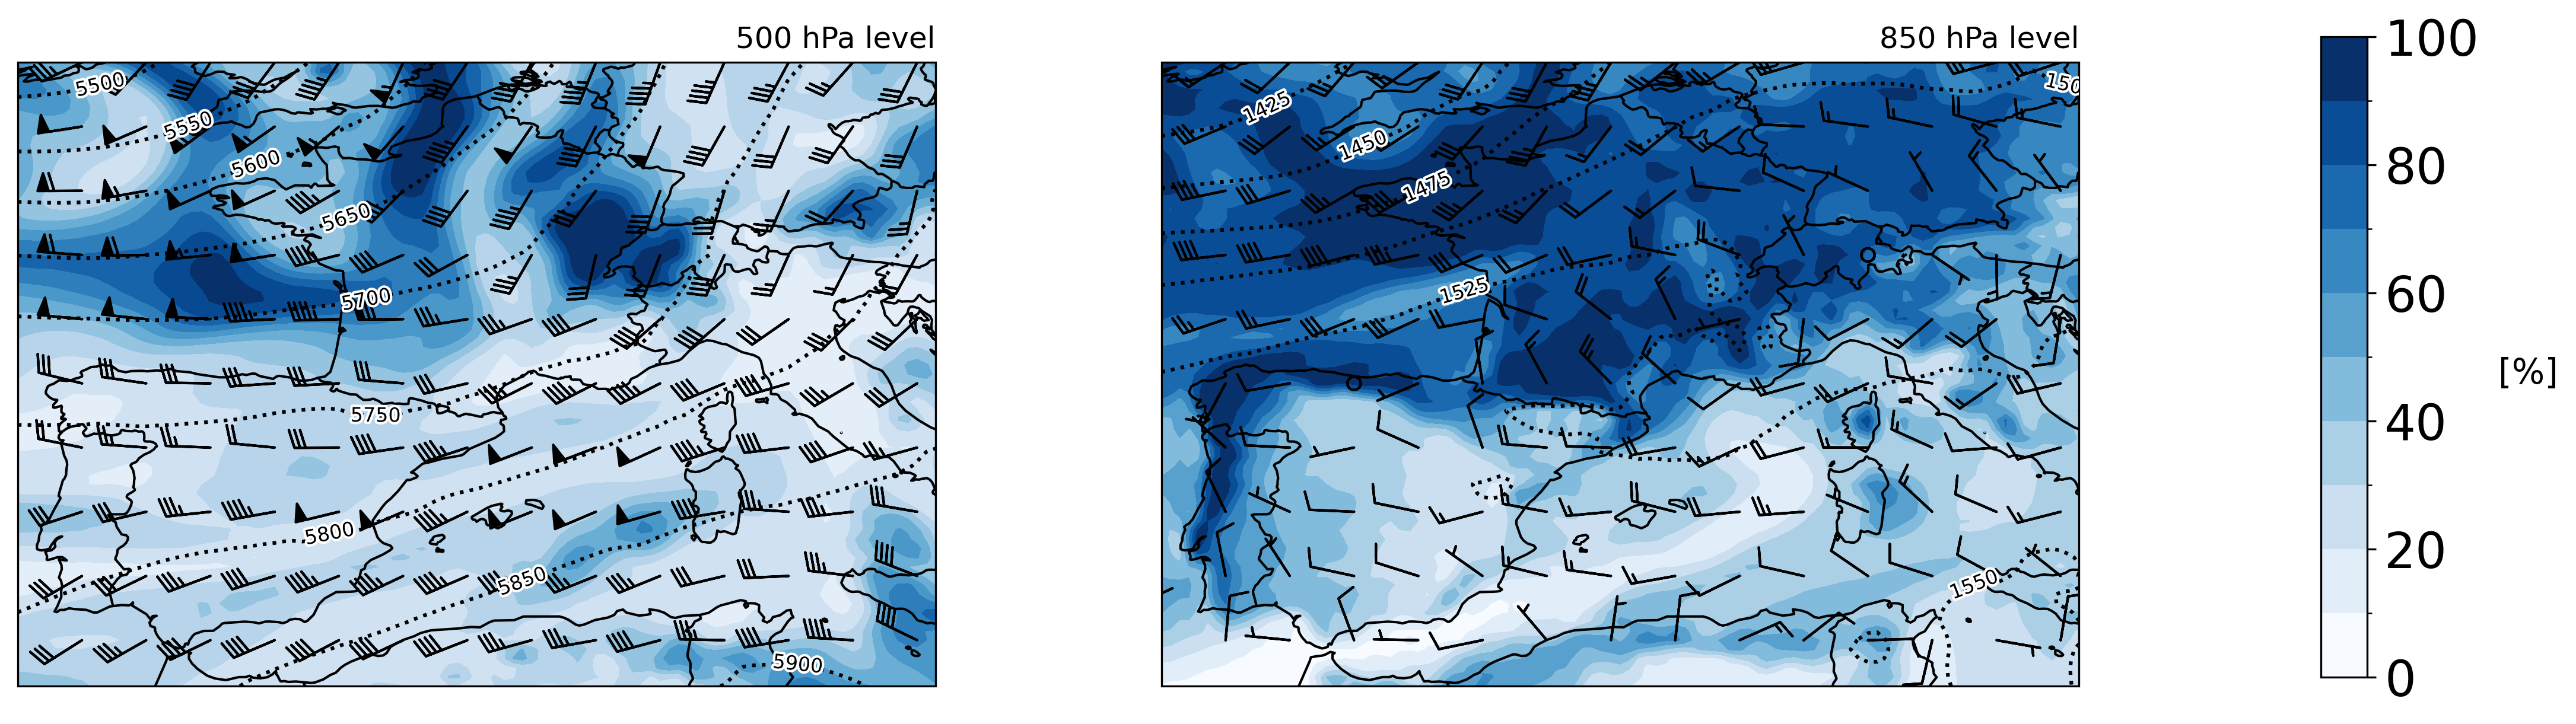

In [51]:
# Create a 2x1 grid of subplots with PlateCarree projection
fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(13, 4), dpi=300)

# Cap the relative humidity data at 100
de['r'] = de['r'].where(de['r'] <= 100, 100)  # Set values above 100 to 100

# Loop over each subplot to add coastlines or other features
for ax in axes:
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)  # Optional: Add borders
    ax.set_extent([-10, 15, 35, 52], crs=projection)

# Define projection for map plotting
projection = ccrs.PlateCarree()

# Select data for the third valid time (index 2), focusing on Western Europe
data_500 = de.r.sel(longitude=slice(-10, 40), latitude=slice(60, 35), pressure_level=500,valid_time=de.valid_time[aim_time]).squeeze()
data_500.plot.contourf(ax=axes[0], transform=projection, levels=r_levels, add_colorbar=False, cmap='Blues')

data_850 = de.r.sel(longitude=slice(-10, 40), latitude=slice(60, 35), pressure_level=850, valid_time=de.valid_time[aim_time]).squeeze()
p = data_850.plot.contourf(ax=axes[1], transform=projection, levels=r_levels, add_colorbar=False, vmin=0, vmax=100, cmap='Blues')

# Plotting contours with black lines
contour_plot_500 = de.z_m.sel(longitude=slice(-10, 15), latitude=slice(52, 35), valid_time=de.valid_time[aim_time], pressure_level=500).squeeze().plot.contour(ax=axes[0], colors='black', linestyles='dotted', levels=z500_levels)
contour_plot_850 = de.z_m.sel(longitude=slice(-10, 15), latitude=slice(52, 35), valid_time=de.valid_time[aim_time], pressure_level=850).squeeze().plot.contour(ax=axes[1], colors='black', linestyles='dotted', levels=z850_levels)
contour_labels_500 = plt.clabel(contour_plot_500, fontsize=8, fmt='%1.0f', inline=False, inline_spacing=5)         
contour_labels_850 = plt.clabel(contour_plot_850, fontsize=8, fmt='%1.0f', inline=False, inline_spacing=5)

# Apply path effects to contour labels
plt.setp(contour_labels_500, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
plt.setp(contour_labels_850, path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
# Adjust spacing between the subplots to avoid overlap

subset = de.sel(longitude=slice(-10, 15, 7), latitude=slice(52, 35, 7), valid_time=de.valid_time[aim_time], pressure_level=500)
longitude = subset['longitude'].values
latitude = subset['latitude'].values
u = subset['u'].values
v = subset['v'].values
# Determine the quiver grid
lon, lat = np.meshgrid(longitude, latitude)
# Now use matplotlib's quiver directly
barbs = axes[0].barbs(lon, lat, u, v, barb_increments=dict(half=2, full=4, flag=20), length=6,
                         transform=ccrs.PlateCarree())

subset = de.sel(longitude=slice(-10, 15, 7), latitude=slice(52, 35, 7), valid_time=de.valid_time[aim_time], pressure_level=850)
longitude = subset['longitude'].values
latitude = subset['latitude'].values
u = subset['u'].values
v = subset['v'].values
# Determine the quiver grid
lon, lat = np.meshgrid(longitude, latitude)
# Now use matplotlib's quiver directly
barbs = axes[1].barbs(lon, lat, u, v, barb_increments=dict(half=2, full=4, flag=20), length=6,
                         transform=ccrs.PlateCarree())


# Adjust the position
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.1, wspace=0.1)

# Create a single colorbar
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9]) 
cbar = plt.colorbar(p, cax=cbar_ax)
cbar.set_label('[%]', labelpad=20, fontsize=14, rotation=360)
cbar.ax.tick_params(labelsize=20)

# Set titles
axes[0].set_title('')
axes[1].set_title('')
axes[0].set_title('500 hPa level', loc='right')
axes[1].set_title('850 hPa level', loc='right')

# Display the figure
plt.tight_layout()
plt.show()

